In [47]:
# 1_eda_and_preprocessing.ipynb 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

nltk.download('punkt')
nltk.download('stopwords')

# 1. Load Data
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")
train_df = pd.DataFrame(dataset['train'])
# create class distribution and text length columns (needed later)
class_dist = train_df['medical_specialty'].value_counts()
train_df['text_length'] = train_df['transcription'].str.len()

# optional: same for val/test so you can inspect them too
val_df['text_length'] = val_df['transcription'].str.len()
test_df['text_length'] = test_df['transcription'].str.len()

val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print("=== Dataset Overview ===")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {train_df['medical_specialty'].nunique()}")

[nltk_data] Downloading package punkt to /home/janani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/janani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Repo card metadata block was not found. Setting CardData to empty.


=== Dataset Overview ===
Training samples: 1724
Validation samples: 370
Test samples: 370
Number of classes: 13


/tmp/ipykernel_29617/1436982514.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_dist.values, y=class_dist.index, palette='viridis', ax=ax1)


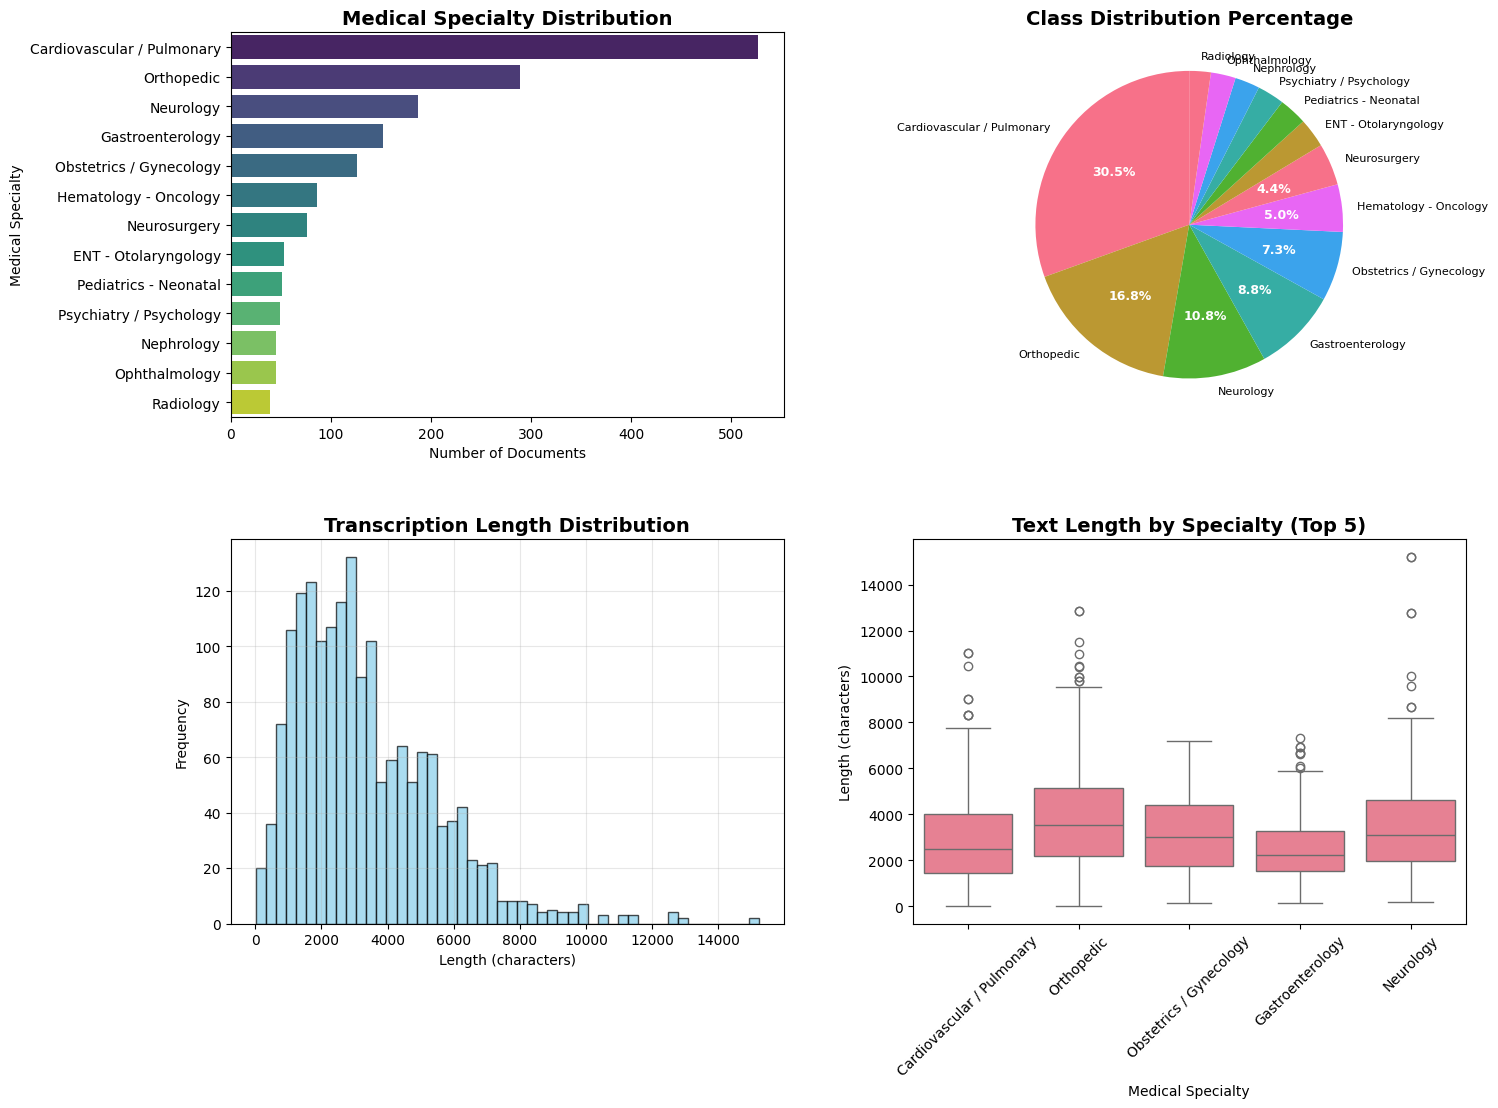

=== Class Distribution Table ===
         Medical Specialty  Count Percentage Cumulative %
Cardiovascular / Pulmonary    526     30.51%       30.51%
                Orthopedic    289     16.76%       47.27%
                 Neurology    187     10.85%       58.12%
          Gastroenterology    152      8.82%       66.94%
   Obstetrics / Gynecology    126      7.31%       74.25%
     Hematology - Oncology     86      4.99%       79.23%
              Neurosurgery     76      4.41%       83.64%
      ENT - Otolaryngology     53      3.07%       86.72%
     Pediatrics - Neonatal     51      2.96%       89.68%
   Psychiatry / Psychology     49      2.84%       92.52%
                Nephrology     45      2.61%       95.13%
             Ophthalmology     45      2.61%       97.74%
                 Radiology     39      2.26%      100.00%


In [44]:
# 2.1 Class Distribution - BEST VERSION
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Bar chart
sns.barplot(x=class_dist.values, y=class_dist.index, palette='viridis', ax=ax1)
ax1.set_title('Medical Specialty Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Documents')
ax1.set_ylabel('Medical Specialty')

# Plot 2: Pie chart with perfect spacing
# Calculate positions to avoid overlap
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%' if pct > 4 else ''
    return my_autopct

wedges, texts, autotexts = ax2.pie(class_dist.values, 
                                  labels=class_dist.index,
                                  autopct=make_autopct(class_dist.values),
                                  startangle=90,
                                  textprops={'fontsize': 9})
ax2.set_title('Class Distribution Percentage', fontsize=14, fontweight='bold')

# Improve text spacing
for text in texts:
    text.set_fontsize(8)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 3: Text length distribution
ax3.hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_title('Transcription Length Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Length (characters)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# Plot 4: Text length by specialty
top_5 = class_dist.index[:5]
top_5_df = train_df[train_df['medical_specialty'].isin(top_5)]
sns.boxplot(data=top_5_df, x='medical_specialty', y='text_length', ax=ax4)
ax4.set_title('Text Length by Specialty (Top 5)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Medical Specialty')
ax4.set_ylabel('Length (characters)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout(pad=4.0)  # Extra padding
plt.show()

# Class distribution table with better formatting
print("=== Class Distribution Table ===")
class_table = pd.DataFrame({
    'Medical Specialty': class_dist.index,
    'Count': class_dist.values,
    'Percentage': (class_dist.values / len(train_df) * 100).round(2),
    'Cumulative %': (class_dist.values.cumsum() / len(train_df) * 100).round(2)
})
print(class_table.to_string(index=False, formatters={
    'Percentage': '{:.2f}%'.format,
    'Cumulative %': '{:.2f}%'.format
}))

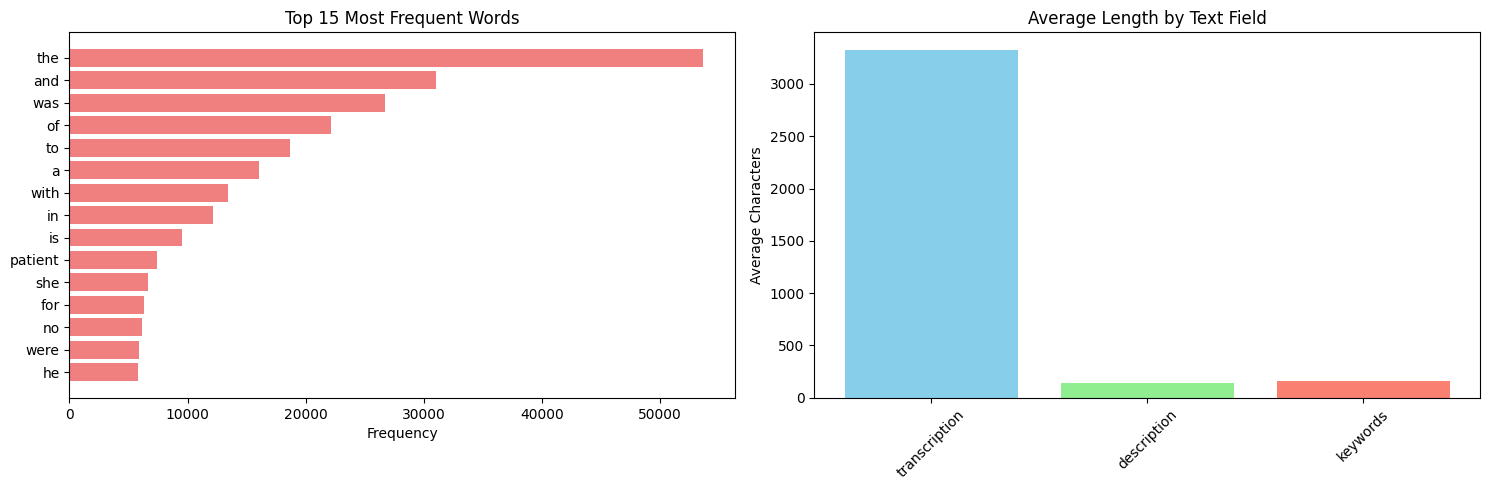

In [37]:
# 2.2 Text Analysis
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

train_df['cleaned_text'] = train_df['transcription'].apply(clean_text)

# Word frequency analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
words = " ".join(train_df['cleaned_text']).split()
word_freq = Counter(words).most_common(15)
words, counts = zip(*word_freq)
plt.barh(words, counts, color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 15 Most Frequent Words')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
# Analyze text field usage
text_fields = ['transcription', 'description', 'keywords']
field_lengths = [train_df[field].apply(lambda x: len(str(x))).mean() for field in text_fields]
plt.bar(text_fields, field_lengths, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Length by Text Field')
plt.ylabel('Average Characters')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

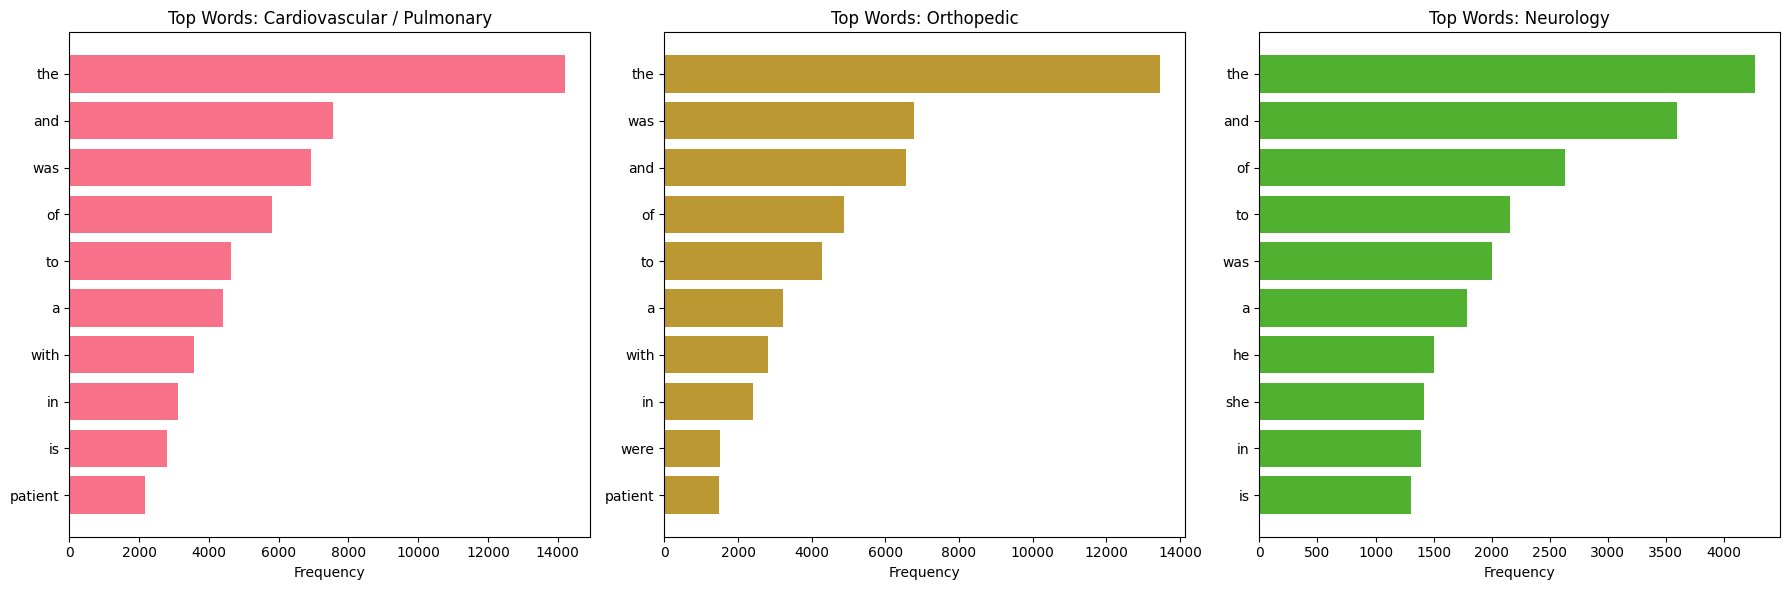

In [38]:
# 2.3 Specialty-specific Analysis
major_specialties = class_dist.index[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, specialty in enumerate(major_specialties):
    specialty_texts = train_df[train_df['medical_specialty'] == specialty]['cleaned_text']
    all_text = " ".join(specialty_texts)
    
    words = all_text.split()
    word_freq = Counter(words).most_common(10)
    
    words, counts = zip(*word_freq)
    axes[i].barh(words, counts, color=f'C{i}')
    axes[i].set_title(f'Top Words: {specialty}')
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
# 3. Key Findings Summary
print("=== KEY EDA FINDINGS ===")
print("\n1. CLASS IMBALANCE:")
print(f"   - Majority class: {class_dist.index[0]} ({class_dist.values[0]} samples)")
print(f"   - Minority class: {class_dist.index[-1]} ({class_dist.values[-1]} samples)")
print(f"   - Imbalance ratio: {class_dist.max()/class_dist.min():.2f}")

print("\n2. TEXT CHARACTERISTICS:")
print(f"   - Average transcription length: {train_df['text_length'].mean():.0f} chars")
print(f"   - Longest transcription: {train_df['text_length'].max()} chars")
print(f"   - Shortest transcription: {train_df['text_length'].min()} chars")

print("\n3. DATA QUALITY:")
print("   - Medical jargon and abbreviations present")
print("   - Structured formatting in some transcriptions")
print("   - Specialty-specific terminology evident")

print("\n4. RECOMMENDATIONS FOR PREPROCESSING:")
print("   - Handle class imbalance in model evaluation")
print("   - Use TF-IDF with appropriate vocabulary limits")
print("   - Consider n-grams for medical terminology")
print("   - Focus on precision/recall for critical specialties")

print(f"\n✅ EDA COMPLETE - Ready for Notebook 2: Classification Modeling")
print(f"   Training data shape: {len(train_df)} samples")
print(f"   Validation data shape: {len(val_df)} samples")
print(f"   Test data shape: {len(test_df)} samples")

=== KEY EDA FINDINGS ===

1. CLASS IMBALANCE:
   - Majority class: Cardiovascular / Pulmonary (526 samples)
   - Minority class: Radiology (39 samples)
   - Imbalance ratio: 13.49

2. TEXT CHARACTERISTICS:
   - Average transcription length: 3326 chars
   - Longest transcription: 15216 chars
   - Shortest transcription: 13 chars

3. DATA QUALITY:
   - Medical jargon and abbreviations present
   - Structured formatting in some transcriptions
   - Specialty-specific terminology evident

4. RECOMMENDATIONS FOR PREPROCESSING:
   - Handle class imbalance in model evaluation
   - Use TF-IDF with appropriate vocabulary limits
   - Consider n-grams for medical terminology
   - Focus on precision/recall for critical specialties

✅ EDA COMPLETE - Ready for Notebook 2: Classification Modeling
   Training data shape: 1724 samples
   Validation data shape: 370 samples
   Test data shape: 370 samples


In [ ]:
# 4. Preprocessing Pipeline with TF-IDF ===
# cleaner step
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return [clean_text(doc) for doc in X]

tfidf_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1,2)
    ))
])

X_tfidf = tfidf_pipeline.fit_transform(train_df['transcription'])
print("TF-IDF feature matrix shape:", X_tfidf.shape)


TF-IDF feature matrix shape: (1724, 5000)
